# Understanding the Impact of Learning Rate in a Deep Neural Network

## Preliminaries

In [2]:
# Necessities
import numpy as np

# Deep Learning
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.optim import Adam

# Data Visualization
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt 
%matplotlib inline

## Global Configuration

In [3]:
class config:
    DATA_DIRECTORY = 'D:/Blog Code/impact-of-learning-rate-in-nn/input/'
    DATA_DOWNLOAD = False

    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    NUM_EPOCHS = 5
    HIGH_LEARNING_RATE = 1e-1
    MEDIUM_LEARNING_RATE = 1e-3
    LOW_LEARNING_RATE = 1e-5
    BATCH_SIZE = 32

# Load Datasets

In [10]:
data = datasets.FashionMNIST(
    config.DATA_DIRECTORY,
    download=config.DATA_DOWNLOAD,
    train=True
    )

In [11]:
fmnist = datasets.FashionMNIST(
    root=config.DATA_DIRECTORY,
    download=config.DATA_DOWNLOAD,
    train=True
    )

tr_images = fmnist.data
tr_targets = fmnist.targets 

val_fmnist = datasets.FashionMNIST(
    config.DATA_DIRECTORY,
    download=config.DATA_DOWNLOAD,
    train=False
    )

val_images = val_fmnist.data 
val_targets = val_fmnist.targets 

# Dataset Class

In [12]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255       # Scaling the Data
        x = x.view(-1,28*28)
        self.x = x
        self.y = y 

    def __getitem__(self, ix):
        x = self.x[ix]
        y = self.y[ix] 

        return x.to(config.DEVICE), y.to(config.DEVICE)
        
    def __len__(self): 
        return len(self.x)

# Model

In [13]:
def get_model(lr):
    """
    Function to obtain the model, loss function and optimizer

    Args:
        lr (float): Learning Rate for Optimizer

    Returns:
        model: A Deel Learning Model
        loss_fn: Loss Function
        optimizer: Optimizer to update parameters
    """
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(config.DEVICE)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = Adam(model.parameters(), lr=lr)
    
    return model, loss_fn, optimizer

# Training and Validation Functions

In [14]:
def train_batch(x, y, model, optimizer, loss_fn):
    """
    Function to train one batch of Training Data

    Args:
        x (numpy array): Input Features
        y (numpy array): Labels
        model: Deep Learning Model
        optimizer: Optimizer
        loss_fn: Loss Function

    Returns:
        batch_loss.item(): Loss value for the batch
    """
    model.train()                       # Set model to training mode
    prediction = model(x)               # Obtain Predictions
    batch_loss = loss_fn(prediction, y) # Calculate Loss for the batch
    batch_loss.backward()               # Backward Propagation of Loss
    optimizer.step()                    # Update Parameters
    optimizer.zero_grad()               # Zero the gradients
    return batch_loss.item()

def accuracy(x, y, model):
    """
    Function to calculate the accuracy of the model

    Args:
        x (numpy array): Input Features
        y (numpy array): Labels
        model: Deep Learning Model

    Returns:
        is_correct.cpu().numpy().tolist() (list): List of correct predictions
    """
    model.eval()                                # Set model to evaluation mode
    with torch.no_grad():                       # Initialize torch.no_grad()
        prediction = model(x)                   # Obtain predictions on evaluation set
    max_values, argmaxes = prediction.max(-1)   # Obtain class prediction with maximum value
    is_correct = argmaxes == y                  # Number of correct predictions
    return is_correct.cpu().numpy().tolist()

# Utilities

In [15]:
def get_data(): 
    """
    Function to obtain the Training and Validation DataLoaders

    Returns:
        train_dl: Training DataLoader
        val_dl: Validation DataLoader
    """
    train = FMNISTDataset(tr_images, tr_targets) 
    train_dl = DataLoader(train, batch_size=config.BATCH_SIZE, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return train_dl, val_dl

In [16]:
@torch.no_grad()
def val_loss(x, y, model):
    """
    Function to calculate Validation Loss

    Args:
        x (numpy array): Input Features
        y (numpy array): Labels
        model: Deep Learning Model

    Returns:
        val_loss.item(): Validation Loss Value
    """
    prediction = model(x)               # Obtain Model Predictions
    val_loss = loss_fn(prediction, y)   # Calculate Validation Loss
    return val_loss.item()

### 1. High Learning Rate (1e-1)

In [26]:
def run(lr):

    # Load Dataloaders
    train_dl, val_dl = get_data()
    
    model, loss_fn, optimizer = get_model(lr)
    
    # Define lists to store losses and accuracies
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(config.NUM_EPOCHS):

        print(f"########## Epoch: {epoch} ##########")

        train_epoch_losses, train_epoch_accuracies = [], []

        for ix, batch in enumerate(iter(train_dl)):
            x, y = batch
            batch_loss = train_batch(
                x, 
                y, 
                model, 
                optimizer, 
                loss_fn
                )
            train_epoch_losses.append(batch_loss) 
            
        train_epoch_loss = np.array(train_epoch_losses).mean()
        print(f"Epoch Train Loss: {train_epoch_loss}")
        print()

        for ix, batch in enumerate(iter(train_dl)):
            x, y = batch
            is_correct = accuracy(x, y, model)
            train_epoch_accuracies.extend(is_correct)

        train_epoch_accuracy = np.mean(train_epoch_accuracies)

        for ix, batch in enumerate(iter(val_dl)):
            x, y = batch
            val_is_correct = accuracy(x, y, model)
            validation_loss = val_loss(x, y, model)
            
        val_epoch_accuracy = np.mean(val_is_correct)
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_losses.append(validation_loss)
        val_accuracies.append(val_epoch_accuracy)

    return 

In [28]:
run(config.HIGH_LEARNING_RATE)

########## Epoch: 0 ##########
Epoch Train Loss: 3.373263525835673

########## Epoch: 1 ##########
Epoch Train Loss: 1.9169347543080648

########## Epoch: 2 ##########
Epoch Train Loss: 1.9461637417475381

########## Epoch: 3 ##########
Epoch Train Loss: 1.9588841822306315

########## Epoch: 4 ##########
Epoch Train Loss: 1.958413743209839



In [29]:
def get_loss_plot(lr):
    """
    Function to plot the training and validation losses

    Args:
        lr (float): Learning Rate on which the model was trained
    """
    epochs = np.arange(config.NUM_EPOCHS)+1

    plt.subplot(211)
    plt.plot(epochs, train_losses, 'bo', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title(f'Training and validation loss with {lr} learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('off')
    plt.show()

    plt.subplot(212)
    plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title(f'Training and validation accuracy with {lr} learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.legend()
    plt.grid('off')
    plt.show()

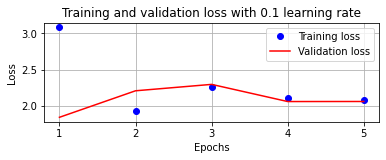

C:\Users\hp\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


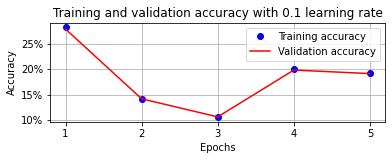

In [30]:
get_loss_plot(config.HIGH_LEARNING_RATE)

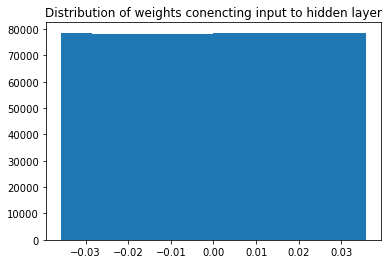

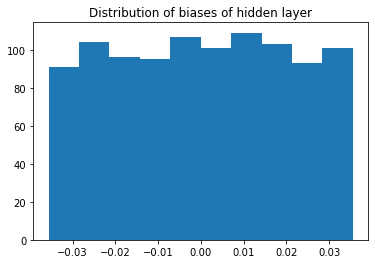

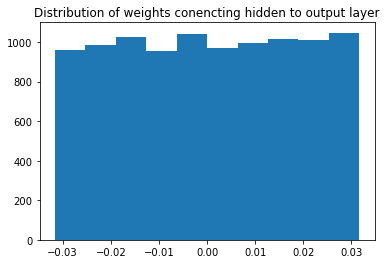

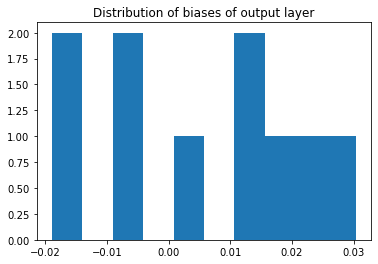

In [32]:
def get_hist_plot():
    for ix, par in enumerate(model.parameters()):
        if(ix==0):
            plt.hist(par.cpu().detach().numpy().flatten())
            plt.title('Distribution of weights conencting input to hidden layer')
            plt.show()
        elif(ix ==1):
            plt.hist(par.cpu().detach().numpy().flatten())
            plt.title('Distribution of biases of hidden layer')
            plt.show()
        elif(ix==2):
            plt.hist(par.cpu().detach().numpy().flatten())
            plt.title('Distribution of weights conencting hidden to output layer')
            plt.show()
        elif(ix ==3):
            plt.hist(par.cpu().detach().numpy().flatten())
            plt.title('Distribution of biases of output layer')
            plt.show() 

get_hist_plot()

### Medium learning rate

In [33]:
run(config.MEDIUM_LEARNING_RATE)

########## Epoch: 0 ##########
Epoch Train Loss: 0.4742165122528871

########## Epoch: 1 ##########
Epoch Train Loss: 0.3584592862447103

########## Epoch: 2 ##########
Epoch Train Loss: 0.31873371261755623

########## Epoch: 3 ##########
Epoch Train Loss: 0.29547413798968

########## Epoch: 4 ##########
Epoch Train Loss: 0.27773971244990825



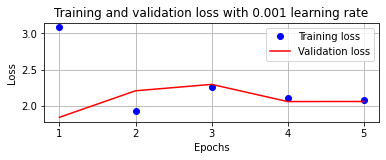

C:\Users\hp\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


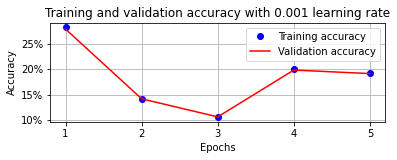

In [36]:
get_loss_plot(config.MEDIUM_LEARNING_RATE)

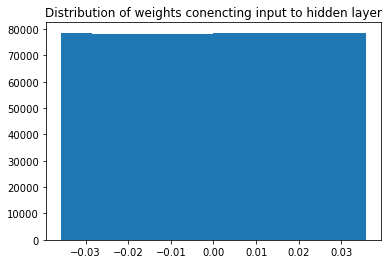

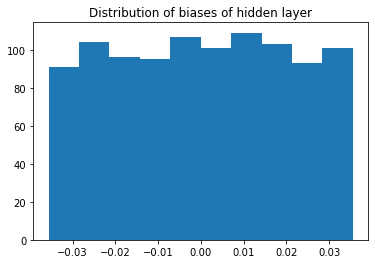

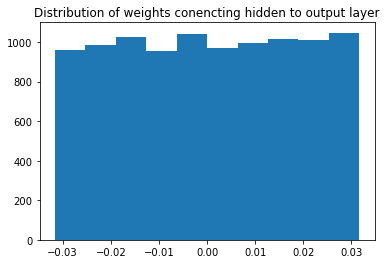

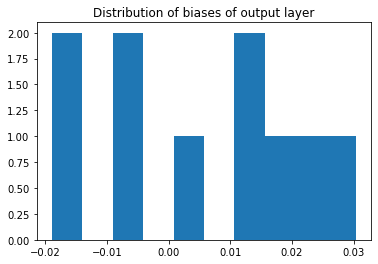

In [37]:
get_hist_plot()

In [23]:
train_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model(config.MEDIUM_LEARNING_RATE)

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


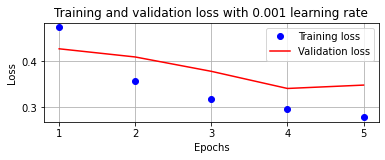

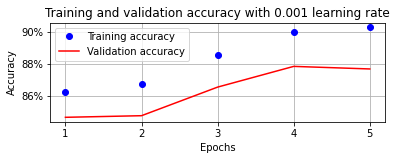

In [ ]:
epochs = np.arange(5)+1

plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

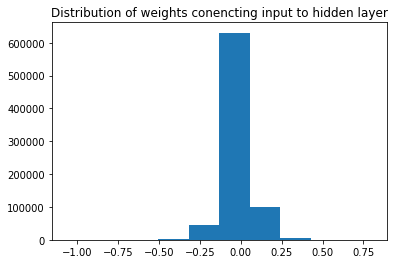

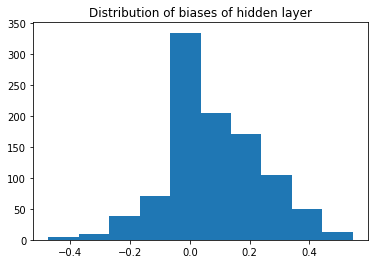

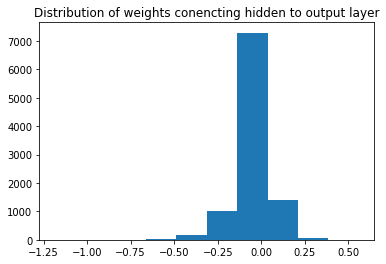

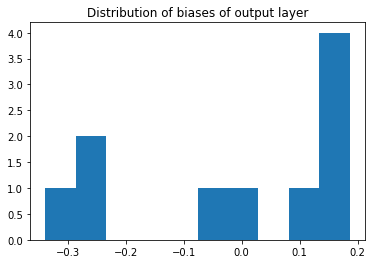

In [ ]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

### Low learning rate

In [ ]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=config.LOW_LEARNING_RATE)
    return model, loss_fn, optimizer 

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


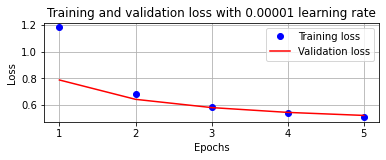

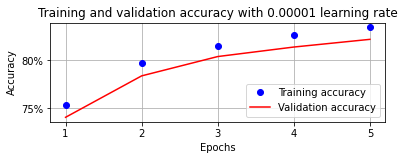

In [ ]:
epochs = np.arange(5)+1

plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.00001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.00001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

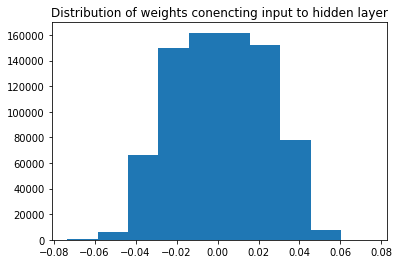

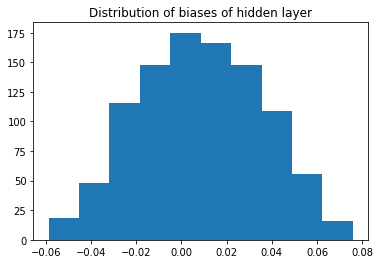

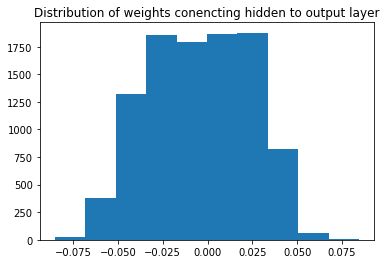

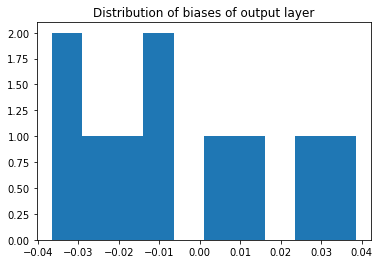

In [ ]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 